In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc  # Imports required for ROC/AUC
from tqdm import tqdm
import kagglehub

In [5]:

config = {
    'data_path': None,
    'dataset_size': 5000000,
    'train_ratio': 0.8,
    'batch_size': 512,
    'epochs': 50,
    'learning_rate': 1e-3,
    'hidden_layers': [300, 300, 300],
    'dropout_p': 0.4,
    'high_level_feats': None,
    'seed': 42,
    'use_cuda':True

}

In [3]:
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])

In [6]:
device = torch.device("cuda" if config['use_cuda'] and torch.cuda.is_available() else "cpu")
print(f"device used: {device}")


device used: cuda


In [7]:
try:
    path = kagglehub.dataset_download("janus137/supersymmetry-dataset")
    config['data_path'] = os.path.join(path, "supersymmetry_dataset.csv")
    print(f"Veri seti '{config['data_path']}' adresine indirildi.")
except Exception as e:
    print(f"KaggleHub'dan veri indirilemedi: {e}")
    print("Lütfen 'data_path'i manuel olarak ayarlayın.")


Veri seti '/kaggle/input/supersymmetry-dataset/supersymmetry_dataset.csv' adresine indirildi.


In [8]:
def load_and_preprocess_data(config):
    """Loads data, selects features, splits, scales, and returns DataLoaders."""
    if not config['data_path'] or not os.path.exists(config['data_path']):
        raise FileNotFoundError(f"Data file not found: {config['data_path']}")

    features = [
        'SUSY', 'lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi',
        'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
        'missing energy magnitude', 'missing energy phi',
        'MET_rel', 'axial MET', 'M_R', 'M_TR2', 'R',
        'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)'
    ]
    high_feats = features[1:9]
    low_feats = features[9:]

    print(f"Reading {config['dataset_size']} rows from '{config['data_path']}'...")
    df=pd.read_csv(config['data_path'], header=None, names=features,skiprows=1)
    X_full = df.drop('SUSY', axis=1)
    y_full = df['SUSY'].astype(np.int64).values

    feature_set_name = ""
    if config['high_level_feats'] is None:
        X_np = X_full.values.astype(np.float32)
        feature_set_name = "All Features"
        print(f"Using {feature_set_name} ({X_np.shape[1]} total).")
    elif config['high_level_feats']:
        X_np = X_full[high_feats].values.astype(np.float32)
        feature_set_name = "High-Level Features"
        print(f"Using only {feature_set_name} ({X_np.shape[1]} total).")
    else: # This scenario isn't run in this script but kept for flexibility
        X_np = X_full[low_feats].values.astype(np.float32)
        feature_set_name = "Low-Level Features"
        print(f"Using only {feature_set_name} ({X_np.shape[1]} total).")

    # Splitting data into Training and Test sets
    train_size = int(config['train_ratio'] * len(X_np))
    test_size = len(X_np) - train_size
    train_indices, test_indices = random_split(
        range(len(X_np)), [train_size, test_size],
        generator=torch.Generator().manual_seed(config['seed'])
    )
    X_train_raw, y_train_np = X_np[train_indices.indices], y_full[train_indices.indices]
    X_test_raw, y_test_np = X_np[test_indices.indices], y_full[test_indices.indices]

    # Data Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    # Converting NumPy arrays to PyTorch Tensors
    X_train = torch.from_numpy(X_train_scaled)
    y_train = torch.from_numpy(y_train_np)
    X_test = torch.from_numpy(X_test_scaled)
    y_test = torch.from_numpy(y_test_np)

    # Creating TensorDataset and DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'] * 2, num_workers=2)

    return train_loader, test_loader, X_train.shape[1]


In [9]:
# --- 3. DNN MODEL ARCHITECTURE ---
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_p):
        super().__init__()
        layers = []
        current_dim = input_dim
        for h_dim in hidden_layers:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
            current_dim = h_dim
        layers.append(nn.Linear(current_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return F.log_softmax(self.net(x), dim=1)


In [10]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in tqdm(loader, desc="Training", leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

def test_epoch(model, loader, device):
    model.eval()
    test_loss, correct = 0.0, 0
    all_targets = []
    all_scores = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

            probs = torch.exp(output)[:, 1]
            all_scores.extend(probs.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    fpr, tpr, _ = roc_curve(all_targets, all_scores)
    roc_auc = auc(fpr, tpr)

    return test_loss, accuracy, roc_auc, fpr, tpr

In [11]:

def run_training(config, device):
    """Trains the model with a single configuration and returns the results."""
    train_loader, test_loader, input_dim = load_and_preprocess_data(config)

    model = DNN(input_dim, config['hidden_layers'], config['dropout_p']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    history = {'train_loss': [], 'test_loss': [], 'test_acc': [], 'test_auc': []}

    print("\n" + "="*60)
    feature_type = "ALL" if config['high_level_feats'] is None else "HIGH-LEVEL"
    print(f"STARTING TRAINING: {feature_type} FEATURES")
    print("="*60)

    # To store the ROC data from the final epoch
    final_roc_data = (None, None, None)

    for epoch in range(1, config['epochs'] + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        test_loss, test_acc, test_auc, fpr, tpr = test_epoch(model, test_loader, device)

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_auc'].append(test_auc)

        print(f"Epoch {epoch:2}/{config['epochs']}: Train Loss={train_loss:.4f} | Test Loss={test_loss:.4f} | Test Acc={test_acc:.3%} | Test AUC={test_auc:.4f}")

        final_roc_data = (fpr, tpr, test_auc)

    print("="*60 + "\n")
    return history, model, final_roc_data



######################################################################
### RUN 1: TRAINING WITH ALL FEATURES ###
######################################################################
Reading 5000000 rows from '/kaggle/input/supersymmetry-dataset/supersymmetry_dataset.csv'...
Using All Features (18 total).

STARTING TRAINING: ALL FEATURES


Epoch  1/50: Train Loss=0.4393 | Test Loss=0.4276 | Test Acc=80.277% | Test AUC=0.8755


Epoch  2/50: Train Loss=0.4334 | Test Loss=0.4269 | Test Acc=80.310% | Test AUC=0.8760


Epoch  3/50: Train Loss=0.4321 | Test Loss=0.4265 | Test Acc=80.299% | Test AUC=0.8763


Epoch  4/50: Train Loss=0.4313 | Test Loss=0.4259 | Test Acc=80.361% | Test AUC=0.8766


Epoch  5/50: Train Loss=0.4310 | Test Loss=0.4257 | Test Acc=80.368% | Test AUC=0.8769


Epoch  6/50: Train Loss=0.4305 | Test Loss=0.4255 | Test Acc=80.349% | Test AUC=0.8768


Epoch  7/50: Train Loss=0.4302 | Test Loss=0.4252 | Test Acc=80.367% | Test AUC=0.8769


Epoch  8/50: Train Loss=0.4301 | Test Loss=0.4257 | Test Acc=80.332% | Test AUC=0.8769


Epoch  9/50: Train Loss=0.4300 | Test Loss=0.4250 | Test Acc=80.387% | Test AUC=0.8771


Epoch 10/50: Train Loss=0.4298 | Test Loss=0.4250 | Test Acc=80.393% | Test AUC=0.8771


Epoch 11/50: Train Loss=0.4297 | Test Loss=0.4250 | Test Acc=80.376% | Test AUC=0.8771


Epoch 12/50: Train Loss=0.4296 | Test Loss=0.4254 | Test Acc=80.389% | Test AUC=0.8772


Epoch 13/50: Train Loss=0.4294 | Test Loss=0.4255 | Test Acc=80.375% | Test AUC=0.8770


Epoch 14/50: Train Loss=0.4292 | Test Loss=0.4247 | Test Acc=80.405% | Test AUC=0.8773


Epoch 15/50: Train Loss=0.4292 | Test Loss=0.4249 | Test Acc=80.382% | Test AUC=0.8772


Epoch 16/50: Train Loss=0.4292 | Test Loss=0.4247 | Test Acc=80.402% | Test AUC=0.8773


Epoch 17/50: Train Loss=0.4292 | Test Loss=0.4247 | Test Acc=80.401% | Test AUC=0.8772


Epoch 18/50: Train Loss=0.4291 | Test Loss=0.4247 | Test Acc=80.413% | Test AUC=0.8774


Epoch 19/50: Train Loss=0.4289 | Test Loss=0.4247 | Test Acc=80.386% | Test AUC=0.8773


Epoch 20/50: Train Loss=0.4289 | Test Loss=0.4249 | Test Acc=80.368% | Test AUC=0.8774


Epoch 21/50: Train Loss=0.4289 | Test Loss=0.4247 | Test Acc=80.376% | Test AUC=0.8774


Epoch 22/50: Train Loss=0.4288 | Test Loss=0.4248 | Test Acc=80.387% | Test AUC=0.8773


Epoch 23/50: Train Loss=0.4287 | Test Loss=0.4245 | Test Acc=80.399% | Test AUC=0.8775


Epoch 24/50: Train Loss=0.4287 | Test Loss=0.4244 | Test Acc=80.422% | Test AUC=0.8774


Epoch 25/50: Train Loss=0.4287 | Test Loss=0.4251 | Test Acc=80.368% | Test AUC=0.8773


Epoch 26/50: Train Loss=0.4287 | Test Loss=0.4244 | Test Acc=80.416% | Test AUC=0.8774


Epoch 27/50: Train Loss=0.4286 | Test Loss=0.4249 | Test Acc=80.413% | Test AUC=0.8774


Epoch 28/50: Train Loss=0.4286 | Test Loss=0.4249 | Test Acc=80.392% | Test AUC=0.8774


Epoch 29/50: Train Loss=0.4286 | Test Loss=0.4247 | Test Acc=80.404% | Test AUC=0.8775


Epoch 30/50: Train Loss=0.4286 | Test Loss=0.4252 | Test Acc=80.369% | Test AUC=0.8776


Epoch 31/50: Train Loss=0.4284 | Test Loss=0.4243 | Test Acc=80.430% | Test AUC=0.8775


Epoch 32/50: Train Loss=0.4284 | Test Loss=0.4248 | Test Acc=80.403% | Test AUC=0.8776


Epoch 33/50: Train Loss=0.4284 | Test Loss=0.4247 | Test Acc=80.434% | Test AUC=0.8776


Epoch 34/50: Train Loss=0.4284 | Test Loss=0.4244 | Test Acc=80.412% | Test AUC=0.8775


Epoch 35/50: Train Loss=0.4283 | Test Loss=0.4242 | Test Acc=80.435% | Test AUC=0.8776


Epoch 36/50: Train Loss=0.4284 | Test Loss=0.4244 | Test Acc=80.430% | Test AUC=0.8776


Epoch 37/50: Train Loss=0.4283 | Test Loss=0.4246 | Test Acc=80.427% | Test AUC=0.8776


Epoch 38/50: Train Loss=0.4283 | Test Loss=0.4244 | Test Acc=80.401% | Test AUC=0.8776


Epoch 39/50: Train Loss=0.4282 | Test Loss=0.4243 | Test Acc=80.437% | Test AUC=0.8776


Epoch 40/50: Train Loss=0.4282 | Test Loss=0.4246 | Test Acc=80.432% | Test AUC=0.8777


Epoch 41/50: Train Loss=0.4282 | Test Loss=0.4242 | Test Acc=80.434% | Test AUC=0.8777


Epoch 42/50: Train Loss=0.4282 | Test Loss=0.4240 | Test Acc=80.438% | Test AUC=0.8777


Epoch 43/50: Train Loss=0.4282 | Test Loss=0.4242 | Test Acc=80.434% | Test AUC=0.8776


Epoch 44/50: Train Loss=0.4281 | Test Loss=0.4245 | Test Acc=80.399% | Test AUC=0.8775


Epoch 45/50: Train Loss=0.4282 | Test Loss=0.4243 | Test Acc=80.420% | Test AUC=0.8777


Epoch 46/50: Train Loss=0.4280 | Test Loss=0.4240 | Test Acc=80.429% | Test AUC=0.8777


Epoch 47/50: Train Loss=0.4280 | Test Loss=0.4244 | Test Acc=80.423% | Test AUC=0.8775


Epoch 48/50: Train Loss=0.4280 | Test Loss=0.4247 | Test Acc=80.403% | Test AUC=0.8776


Epoch 49/50: Train Loss=0.4279 | Test Loss=0.4242 | Test Acc=80.417% | Test AUC=0.8777


Epoch 50/50: Train Loss=0.4280 | Test Loss=0.4246 | Test Acc=80.400% | Test AUC=0.8776



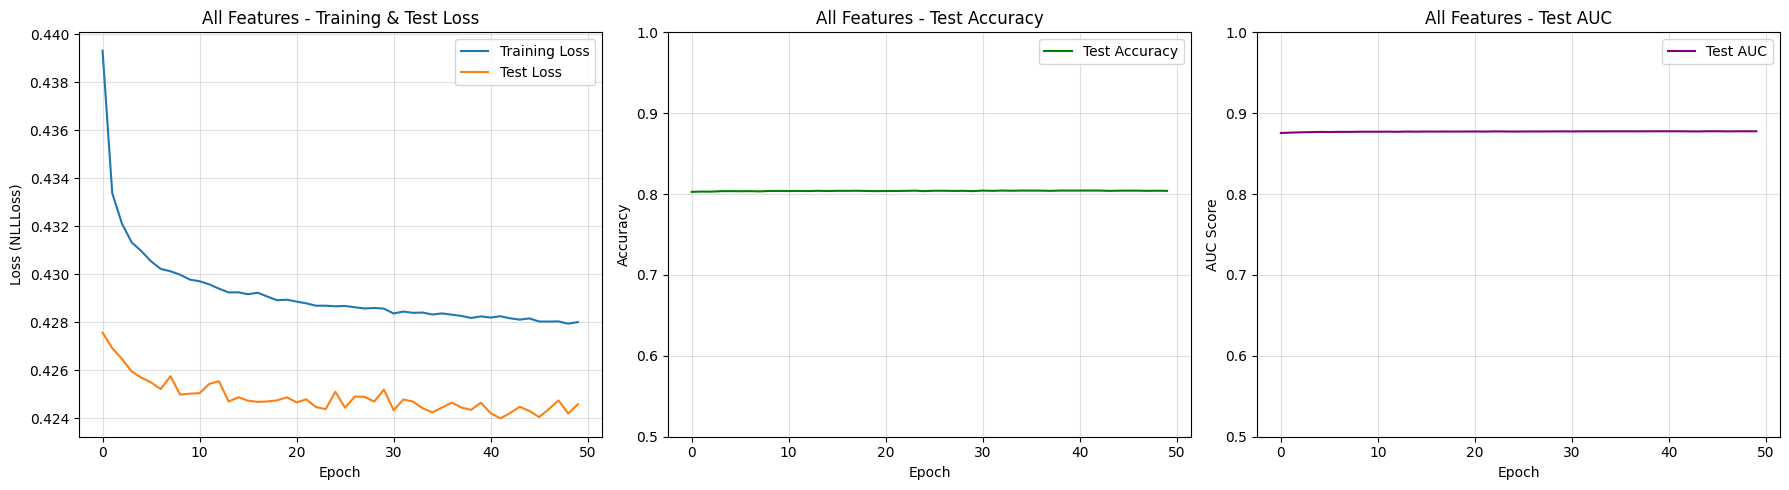


######################################################################
### RUN 2: TRAINING WITH HIGH-LEVEL FEATURES ONLY ###
######################################################################
Reading 5000000 rows from '/kaggle/input/supersymmetry-dataset/supersymmetry_dataset.csv'...
Using only High-Level Features (8 total).

STARTING TRAINING: HIGH-LEVEL FEATURES


Epoch  1/50: Train Loss=0.4582 | Test Loss=0.4405 | Test Acc=79.509% | Test AUC=0.8688


Epoch  2/50: Train Loss=0.4463 | Test Loss=0.4357 | Test Acc=79.805% | Test AUC=0.8715


Epoch  3/50: Train Loss=0.4434 | Test Loss=0.4329 | Test Acc=79.975% | Test AUC=0.8723


Epoch  4/50: Train Loss=0.4419 | Test Loss=0.4334 | Test Acc=79.977% | Test AUC=0.8726


Epoch  5/50: Train Loss=0.4412 | Test Loss=0.4330 | Test Acc=79.986% | Test AUC=0.8730


Epoch  6/50: Train Loss=0.4408 | Test Loss=0.4322 | Test Acc=80.031% | Test AUC=0.8730


Epoch  7/50: Train Loss=0.4403 | Test Loss=0.4318 | Test Acc=80.074% | Test AUC=0.8732


Epoch  8/50: Train Loss=0.4400 | Test Loss=0.4319 | Test Acc=80.031% | Test AUC=0.8734


Epoch  9/50: Train Loss=0.4398 | Test Loss=0.4324 | Test Acc=80.017% | Test AUC=0.8737


Epoch 10/50: Train Loss=0.4394 | Test Loss=0.4316 | Test Acc=80.042% | Test AUC=0.8735


Epoch 11/50: Train Loss=0.4392 | Test Loss=0.4314 | Test Acc=80.102% | Test AUC=0.8736


Epoch 12/50: Train Loss=0.4390 | Test Loss=0.4307 | Test Acc=80.101% | Test AUC=0.8738


Epoch 13/50: Train Loss=0.4388 | Test Loss=0.4312 | Test Acc=80.063% | Test AUC=0.8739


Epoch 14/50: Train Loss=0.4387 | Test Loss=0.4304 | Test Acc=80.118% | Test AUC=0.8741


Epoch 15/50: Train Loss=0.4388 | Test Loss=0.4321 | Test Acc=80.041% | Test AUC=0.8737


Epoch 16/50: Train Loss=0.4386 | Test Loss=0.4310 | Test Acc=80.057% | Test AUC=0.8739


Epoch 17/50: Train Loss=0.4385 | Test Loss=0.4306 | Test Acc=80.120% | Test AUC=0.8740


Epoch 18/50: Train Loss=0.4385 | Test Loss=0.4305 | Test Acc=80.131% | Test AUC=0.8741


Epoch 19/50: Train Loss=0.4384 | Test Loss=0.4304 | Test Acc=80.137% | Test AUC=0.8742


Epoch 20/50: Train Loss=0.4381 | Test Loss=0.4305 | Test Acc=80.120% | Test AUC=0.8741


Epoch 21/50: Train Loss=0.4382 | Test Loss=0.4306 | Test Acc=80.095% | Test AUC=0.8740


Epoch 22/50: Train Loss=0.4380 | Test Loss=0.4309 | Test Acc=80.131% | Test AUC=0.8741


Epoch 23/50: Train Loss=0.4380 | Test Loss=0.4316 | Test Acc=80.094% | Test AUC=0.8739


Epoch 24/50: Train Loss=0.4379 | Test Loss=0.4307 | Test Acc=80.128% | Test AUC=0.8740


Epoch 25/50: Train Loss=0.4380 | Test Loss=0.4303 | Test Acc=80.116% | Test AUC=0.8743


Epoch 26/50: Train Loss=0.4380 | Test Loss=0.4296 | Test Acc=80.161% | Test AUC=0.8742


Epoch 27/50: Train Loss=0.4377 | Test Loss=0.4312 | Test Acc=80.122% | Test AUC=0.8742


Epoch 28/50: Train Loss=0.4377 | Test Loss=0.4311 | Test Acc=80.133% | Test AUC=0.8742


Epoch 29/50: Train Loss=0.4377 | Test Loss=0.4306 | Test Acc=80.128% | Test AUC=0.8742


Epoch 30/50: Train Loss=0.4377 | Test Loss=0.4303 | Test Acc=80.139% | Test AUC=0.8741


Epoch 31/50: Train Loss=0.4376 | Test Loss=0.4300 | Test Acc=80.145% | Test AUC=0.8743


Epoch 32/50: Train Loss=0.4377 | Test Loss=0.4299 | Test Acc=80.151% | Test AUC=0.8741


Epoch 33/50: Train Loss=0.4376 | Test Loss=0.4313 | Test Acc=80.074% | Test AUC=0.8741


Epoch 34/50: Train Loss=0.4376 | Test Loss=0.4303 | Test Acc=80.113% | Test AUC=0.8742


Epoch 35/50: Train Loss=0.4376 | Test Loss=0.4301 | Test Acc=80.155% | Test AUC=0.8742


Epoch 36/50: Train Loss=0.4376 | Test Loss=0.4293 | Test Acc=80.177% | Test AUC=0.8744


Epoch 37/50: Train Loss=0.4376 | Test Loss=0.4298 | Test Acc=80.155% | Test AUC=0.8743


Epoch 38/50: Train Loss=0.4374 | Test Loss=0.4300 | Test Acc=80.165% | Test AUC=0.8743


Training:  94%|█████████▍| 7360/7813 [00:28<00:02, 212.84it/s]

In [ ]:
def plot_history(history, title_prefix):
    """Plots the training history (loss, accuracy, AUC)."""
    plt.figure(figsize=(18, 5))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f"{title_prefix} - Training & Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLLLoss)")
    plt.legend()
    plt.grid(True, alpha=0.4)

    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(history['test_acc'], label='Test Accuracy', color='green')
    plt.title(f"{title_prefix} - Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0.5, 1)
    plt.legend()
    plt.grid(True, alpha=0.4)

    # AUC Plot
    plt.subplot(1, 3, 3)
    plt.plot(history['test_auc'], label='Test AUC', color='purple')
    plt.title(f"{title_prefix} - Test AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC Score")
    plt.ylim(0.5, 1)
    plt.legend()
    plt.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':


    print("\n" + "#"*70)
    print("### RUN 1: TRAINING WITH ALL FEATURES ###")
    print("#"*70)

    config_all_feats = config.copy()
    config_all_feats['high_level_feats'] = None
    history_all, model_all, roc_data_all = run_training(config_all_feats, device)
    plot_history(history_all, "All Features")


    print("\n" + "#"*70)
    print("### RUN 2: TRAINING WITH HIGH-LEVEL FEATURES ONLY ###")
    print("#"*70)

    config_high_feats = config.copy()
    config_high_feats['high_level_feats'] = True
    history_high, model_high, roc_data_high = run_training(config_high_feats, device)
    plot_history(history_high, "High-Level Features")


    print("\n" + "#"*70)
    print("### RESULT: COMPARING ROC CURVES ###")
    print("#"*70)

    fpr_all, tpr_all, auc_all = roc_data_all
    fpr_high, tpr_high, auc_high = roc_data_high

    plt.figure(figsize=(10, 8))


    plt.plot(fpr_all, tpr_all, color='blue', lw=2,
             label=f'All Features (AUC = {auc_all:.4f})')

    plt.plot(fpr_high, tpr_high, color='red', lw=2, linestyle='--',
             label=f'Low-Level Features Only (AUC = {auc_high:.4f})')


    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', label='Random Chance')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title('Comparison of ROC Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.5)
    plt.show()

